In [23]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
import numpy.random as npr
import qutip as qt

In [2]:
def J1J2_hamiltonian(N, j1, j2):
    id = qt.qeye(2)
    x = qt.sigmax()
    y = qt.sigmay()
    z = qt.sigmaz()
    sxi = []; syi = []; szi = []
    for i in range(N):
        sxi.append(qt.tensor([id] * i + [x] + [id] * (N - i - 1)))
        syi.append(qt.tensor([id] * i + [y] + [id] * (N - i - 1)))
        szi.append(qt.tensor([id] * i + [z] + [id] * (N - i - 1)))
    sis = [sxi, syi, szi]
    J1_term = j1 * (sum(sis[coord][i] * sis[coord][i + 1] for coord in range(len(sis)) for i in range(N - 1)) + sum(sis[coord][N - 1] * sis[coord][0] for coord in range(len(sis))))
    J2_term = j2 * (sum(sis[coord][i] * sis[coord][i + 2] for coord in range(len(sis)) for i in range(N - 2)) + sum(sis[coord][N - 2] * sis[coord][0] for coord in range(len(sis))) + sum(sis[coord][N - 1] * sis[coord][1] for coord in range(len(sis))))
    return J1_term + J2_term

In [3]:
N = 10

In [4]:
eigs10 = J1J2_hamiltonian(N, 1, 0).eigenstates()

In [5]:
for i in range(0, 2 ** N):
    print(bin(i), round(eigs10[1][0][i][0], 5))

0b0 0j
0b1 0j
0b10 (-0+0j)
0b11 (-0+0j)
0b100 (-0+0j)
0b101 0j
0b110 (-0+0j)
0b111 0j
0b1000 (-0+0j)
0b1001 (-0+0j)
0b1010 0j
0b1011 0j
0b1100 (-0+0j)
0b1101 0j
0b1110 0j
0b1111 (-0+0j)
0b10000 (-0+0j)
0b10001 (-0+0j)
0b10010 (-0+0j)
0b10011 (-0+0j)
0b10100 (-0+0j)
0b10101 0j
0b10110 (-0+0j)
0b10111 0j
0b11000 (-0+0j)
0b11001 (-0+0j)
0b11010 0j
0b11011 (-0+0j)
0b11100 0j
0b11101 (-0+0j)
0b11110 0j
0b11111 (0.00048+0j)
0b100000 (-0+0j)
0b100001 (-0+0j)
0b100010 0j
0b100011 (-0+0j)
0b100100 0j
0b100101 (-0+0j)
0b100110 0j
0b100111 (-0+0j)
0b101000 0j
0b101001 0j
0b101010 (-0+0j)
0b101011 0j
0b101100 0j
0b101101 0j
0b101110 (-0+0j)
0b101111 (-0.0029-0j)
0b110000 0j
0b110001 (-0+0j)
0b110010 0j
0b110011 (-0+0j)
0b110100 0j
0b110101 0j
0b110110 (-0+0j)
0b110111 (0.00637+0j)
0b111000 (-0+0j)
0b111001 (-0+0j)
0b111010 0j
0b111011 (-0.00637-0j)
0b111100 (-0+0j)
0b111101 (0.0029+0j)
0b111110 (-0.00048-0j)
0b111111 (-0-0j)
0b1000000 0j
0b1000001 (-0+0j)
0b1000010 (-0+0j)
0b1000011 (-0-0j)
0b1000

C:\Users\taoha\AppData\Local\Temp\ipykernel_31380\2950618481.py:2: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  print(bin(i), round(eigs10[1][0][i][0], 5))


In [6]:
def count_half_magnetization(state): 
    """
    Counts number of 1s in binary representation of some integer
    With integer encoding of state such that 1 in binary representation 
    is spin down and 0 is spin up. Returns number of spin downs.
    """
    if state == 0: return 0
    return sum((state >> n) & 1 for n in range(0, int(np.log2(state)) + 1, 2))

In [7]:
states = []
signs = []
for i in range(0, 2 ** N):
    val = eigs10[1][0][i][0].real
    if abs(val) > 1e-10: # the correct threshold to use is sort of weird
        states.append(i)
        signs.append(-1 + 2 * int(val > 0))

In [8]:
pred_signs =  [-1 + 2 * (count_half_magnetization(i) % 2) for i in states]

In [9]:
print(len(states))
for state, true, calc in zip(states, signs, pred_signs):
    if true != calc:
        print(f'fail {bin(state)}, val {eigs10[1][0][state][0].real}, pred {calc}')
print('success')


252
success


In [10]:
sampled_input = utils.generate_input_samples(N, states)
pred_signs = torch.tensor(pred_signs).reshape((-1, 1))
dataset = {'train_input': sampled_input, 'train_label': pred_signs, 'test_input': sampled_input, 'test_label': pred_signs}

In [11]:
[n for n in sampled_input]

[tensor([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 0., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 0., 1., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 1., 1., 1., 0., 0., 0., 0.]),
 tensor([0., 1., 1., 1., 1., 1., 0., 0., 0., 0.]),
 tensor([1., 1., 1., 1., 0., 0., 1., 0., 0., 0.]),
 tensor([1., 1., 1., 0., 1., 0., 1., 0., 0., 0.]),
 tensor([1., 1., 0., 1., 1., 0., 1., 0., 0., 0.]),
 tensor([1., 0., 1., 1., 1., 0., 1., 0., 0., 0.]),
 tensor([0., 1., 1., 1., 1., 0., 1., 0., 0., 0.]),
 tensor([1., 1., 1., 0., 0., 1., 1., 0., 0., 0.]),
 tensor([1., 1., 0., 1., 0., 1., 1., 0., 0., 0.]),
 tensor([1., 0., 1., 1., 0., 1., 1., 0., 0., 0.]),
 tensor([0., 1., 1., 1., 0., 1., 1., 0., 0., 0.]),
 tensor([1., 1., 0., 0., 1., 1., 1., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 1., 0., 0., 0.]),
 tensor([0., 1., 1., 0., 1., 1., 1., 0., 0., 0.]),
 tensor([1., 0., 0., 1., 1., 1., 1., 0., 0., 0.]),
 tensor([0., 1., 0., 1., 1., 1.

In [12]:
pred_signs

tensor([[ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
      

In [32]:
sampling_kan = kan.KAN(width=[N, 2, 1])
sampling_kan(dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0


In [33]:
sampling_kan.fit(dataset, opt="LBFGS", steps=50, lamb=0);

| train_loss: 9.75e-05 | test_loss: 9.75e-05 | reg: 1.42e+01 | : 100%|█| 50/50 [00:03<00:00, 15.68it

saving model version 0.1


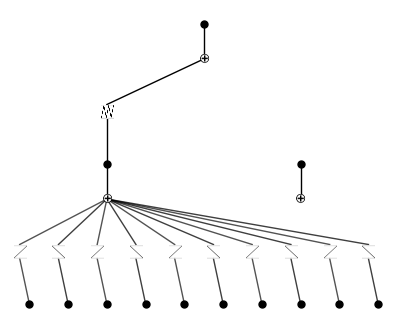

In [34]:
sampling_kan.plot()

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      sin    1.000000 -16.644454           2                2   -1.728891
1      cos    1.000000 -16.644454           2                2   -1.728891
2      tan    1.000000 -16.644454           3                3   -0.928891
3        0    0.000000   0.000014           0                0    0.000003
4        x    0.020544  -0.029933           1                1    0.794013


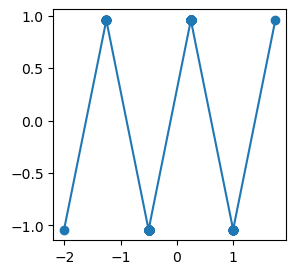

In [35]:
sampling_kan.get_fun(1, 0, 0);
sampling_kan.suggest_symbolic(1, 0, 0);

saving model version 0.2


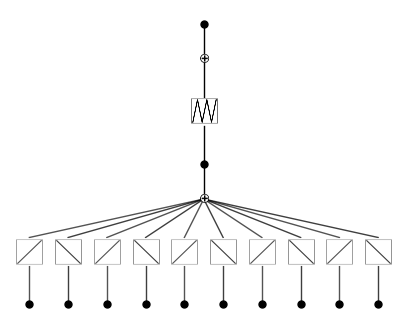

In [36]:
sampling_kan = sampling_kan.prune()
sampling_kan.plot()

In [37]:
sampling_kan.auto_symbolic()

fixing (0,0,0) with x, r2=1.000001072883606, c=1
fixing (0,1,0) with x, r2=1.0000008344650269, c=1
fixing (0,2,0) with x, r2=1.000001072883606, c=1
fixing (0,3,0) with x, r2=1.000001072883606, c=1
fixing (0,4,0) with x, r2=1.000001072883606, c=1
fixing (0,5,0) with x, r2=1.0000011920928955, c=1
fixing (0,6,0) with x, r2=1.000001072883606, c=1
fixing (0,7,0) with x, r2=1.0000009536743164, c=1
fixing (0,8,0) with x, r2=1.0000005960464478, c=1
fixing (0,9,0) with x, r2=1.000001072883606, c=1
fixing (1,0,0) with cos, r2=1.0000003576278687, c=2
saving model version 0.3


In [38]:
sampling_kan.fit(dataset, opt='LBFGS', steps=50);

| train_loss: 1.30e-08 | test_loss: 1.25e-08 | reg: 0.00e+00 | : 100%|█| 50/50 [00:01<00:00, 32.89it

saving model version 0.4


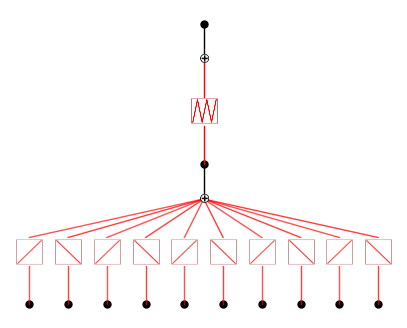

In [39]:
sampling_kan.plot()

In [40]:
ku.ex_round(sampling_kan.symbolic_formula()[0][0], 4)

1.0018*cos(-1.4247*x_1 + 1.7169*x_10 + 1.7169*x_2 - 1.4247*x_3 + 1.7169*x_4 - 1.4247*x_5 + 1.7169*x_6 - 1.4247*x_7 + 1.7169*x_8 - 1.4247*x_9 + 0.8999)

In [ ]:
# eigs12 = J1J2_hamiltonian(12, 1, 0).eigenstates()

In [ ]:
# eigs12[0]

array([-21.54956367, -20.12617361, -20.12617361, ...,  12.        ,
        12.        ,  12.        ])

In [ ]:
# eigs12[1][0]

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(4096, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 3.47816340e-52]
 [-1.52575097e-17]
 ...
 [ 7.24291764e-52]
 [ 1.94089486e-52]
 [ 0.00000000e+00]]

In [ ]:
# qt.qsave(eigs12[1][0], 'n12gs')

In [41]:
gs12 = qt.qload('n12gs')

In [42]:
gs12

Quantum object: dims=[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape=(4096, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00]
 [ 3.47816340e-52]
 [-1.52575097e-17]
 ...
 [ 7.24291764e-52]
 [ 1.94089486e-52]
 [ 0.00000000e+00]]

In [43]:
N = 12

In [44]:
states = []
signs = []
for i in range(0, 2 ** N):
    val = gs12[i][0].real
    if abs(val) > 1e-15: # the correct threshold to use is sort of weird
        states.append(i)
        signs.append(-1 + 2 * int(val > 0))
pred_signs =  [-1 + 2 * (count_half_magnetization(i) % 2) for i in states]
print(len(states))
for state, true, calc in zip(states, signs, pred_signs):
    if true != calc:
        print(f'fail {bin(state)}, val {gs12[state][0].real}, pred {calc}')
print('success')


924
success


In [45]:
sampled_input = utils.generate_input_samples(N, states)
sampled_labels = torch.tensor(pred_signs).reshape((-1, 1))
dataset = {'train_input':sampled_input, 'train_label':sampled_labels, 'test_input':sampled_input, 'test_label':sampled_labels}

In [46]:
sampled_labels

tensor([[ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
        [ 1],
        [-1],
      

In [47]:
sampling_kan = kan.KAN(width=[N, 2, 1], seed=1)
sampling_kan(dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0


In [48]:
sampling_kan.fit(dataset, opt = 'LBFGS', steps=50, lamb=0);

| train_loss: 7.64e-01 | test_loss: 7.64e-01 | reg: 8.66e+01 | : 100%|█| 50/50 [00:11<00:00,  4.52it

saving model version 0.1


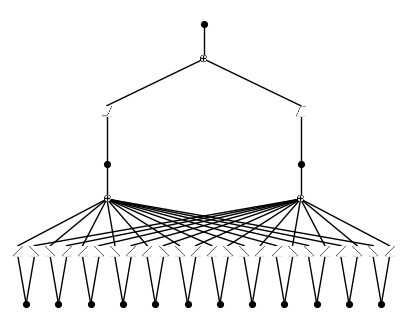

In [49]:
sampling_kan.plot()

In [ ]:
eigs14 = J1J2_hamiltonian(14, 1, 0).eigenstates() # not enough memory
print(eigs14[0])
qt.qsave(eigs14[1][0], 'n14gs')

MemoryError: Unable to allocate 4.00 GiB for an array with shape (16384, 16384) and data type complex128

In [159]:
N = 8

In [160]:
gs8 = J1J2_hamiltonian(N, 1, 0).eigenstates()[1][0]

In [ ]:
states = []
signs = []
for i in range(0, 2 ** N):
    val = gs8[i][0].real
    if abs(val) > 1e-10: # the correct threshold to use is sort of weird
        states.append(i)
        signs.append(-1 + 2 * int(val > 0))
pred_signs =  [-1 + 2 * (count_half_magnetization(i) % 2) for i in states]
print(len(states))
for state, true, calc in zip(states, signs, pred_signs):
    if true != calc:
        print(f'fail {bin(state)}, val {eigs12[1][0][state][0].real}, pred {calc}')
print('success')
dataset = {'train_input': sampled_input, 'train_label': pred_signs, 'test_input': sampled_input, 'test_label': pred_signs}


70
success


In [173]:
sampling_kan = kan.KAN(width=[N, N, 1])
sampling_kan(dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0


In [174]:
sampling_kan.fit(dataset, opt="LBFGS", steps=50, lamb=0);

description:   0%|                                                           | 0/50 [00:00<?, ?it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

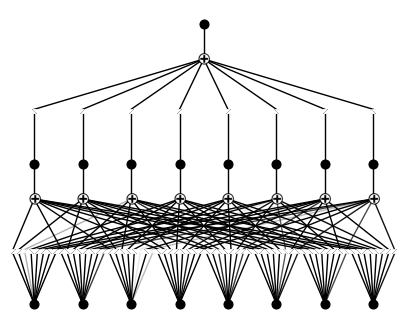

In [168]:
sampling_kan.plot()